In [1]:
%load_ext autoreload
%load_ext autotime
%autoreload 2

## Imports & Settings

In [2]:
import os, sys
import warnings

# setting project path
gparent = os.path.join(os.pardir, os.pardir)
sys.path.append(gparent)

# disabling log messages from TF
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# creating an end of run alarm
from IPython.display import Audio
sound_file = '/Users/dsbox/Documents/Flatiron/phase_5/WAILERLP.wav'

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz
%matplotlib inline

# setting style
sns.set_theme('talk')
plt.style.use('fivethirtyeight')
sns.set_palette('GnBu_r')
pd.options.display.max_rows = 300

from src import helper_functions as f
from src import visualizations as v
from src import class_Database as d
from src import class_Harness as h

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.pipeline import make_pipeline 
from sklearn.metrics import (accuracy_score, recall_score, precision_score,
                             f1_score, make_scorer, confusion_matrix)
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC 
from sklearn.tree import DecisionTreeClassifier, export_graphviz, plot_tree
from sklearn.ensemble import (BaggingClassifier, AdaBoostClassifier,
                              RandomForestClassifier, VotingClassifier)

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline as make_sm_pipeline

# import xgboost as xgb
from xgboost import XGBClassifier, plot_importance

from keras import layers, models, optimizers, losses, metrics
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier

time: 6.36 s


## Creating The Database

In [3]:
# creating database & database class instance
database_name = 'outcomes.db'
db = d.Database(database_name)

time: 1.67 ms


**Run The Cell Below Once And Then Comment Out**

In [4]:
# file_name = 'anonymisedData.zip'
# db.populate(file_name, database_name)

time: 601 µs


### Database ERD

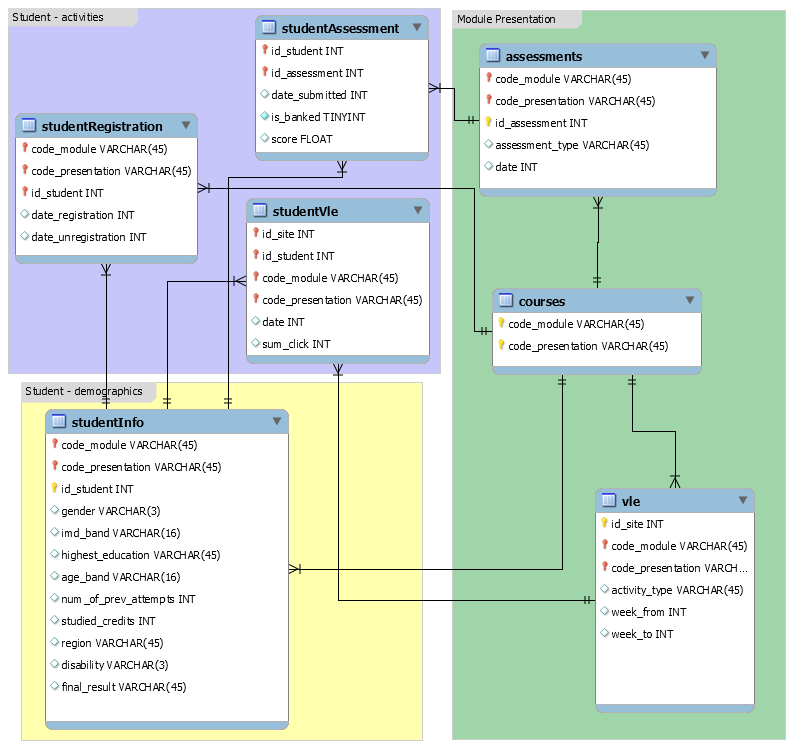

time: 4.29 ms


In [5]:
db.erd

## Preprocessing and Harness Objects

In [6]:
string_selector = make_column_selector(dtype_include='object')
number_selector = make_column_selector(dtype_include='number', dtype_exclude='object')

preprocessing_ohe = make_column_transformer((OneHotEncoder
                                         (handle_unknown='ignore'),string_selector))
preprocessing_ss = make_column_transformer((OneHotEncoder
                                         (handle_unknown='ignore'),string_selector),
                                          (StandardScaler(), number_selector))
preprocessing_mm = make_column_transformer((OneHotEncoder
                                         (handle_unknown='ignore'),string_selector),
                                          (MinMaxScaler(), number_selector))
sm = SMOTE(random_state=2021)

time: 1.92 ms


In [7]:
# creating accuracy scorer
accuracy = f.acc_score

# creating f1 scorer
f1 = f.f1

# creating recall scorer 
recall = f.recall

# creating precision scorer
precision = f.precision

# creating Harness
modeling = h.Harness(('accuracy', 'f1', 'recall', 'precision'))

time: 4.04 ms


In [8]:
path = os.path.join(gparent, 'data/processed/q2.csv')
df = pd.read_csv(path)

time: 76.3 ms


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23010 entries, 0 to 23009
Data columns (total 27 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   gender                      23010 non-null  object 
 1   region                      23010 non-null  object 
 2   highest_education           23010 non-null  object 
 3   imd_band                    22098 non-null  object 
 4   age_band                    23010 non-null  object 
 5   num_of_prev_attempts        23010 non-null  int64  
 6   studied_credits             23010 non-null  int64  
 7   disability                  23010 non-null  object 
 8   final_result                23010 non-null  object 
 9   id_assessment               23010 non-null  int64  
 10  date_submitted              23010 non-null  int64  
 11  is_banked                   23010 non-null  int64  
 12  score                       22987 non-null  float64
 13  course_length               230

In [10]:
df.describe()

,num_of_prev_attempts,studied_credits,id_assessment,date_submitted,is_banked,score,course_length,date_shift,target,weighted_ave,mean_score,id_site,date,sum_click,module_presentation_length,click_sum,num_activities,date_registration,date_unregistration
count,23010.000000,23010.000000,23010.000000,23010.000000,23010.000000,22987.000000,23010.000000,23010.000000,23010.000000,23005.000000,23005.000000,23010.000000,23010.000000,23010.000000,23010.000000,23010.000000,23010.000000,23010.000000,2009.000000
mean,0.148501,75.314429,25466.429161,24.912777,0.003868,73.424414,239.678444,49.912777,0.337288,86.569463,75.205800,743788.946588,-8.844894,2.734376,256.093742,792.284963,223.233203,-65.677749,170.524141
std,0.457578,37.107281,8791.874482,12.924222,0.062073,21.030561,5.641752,12.924222,0.472794,56.620659,15.718019,125362.892973,10.814963,5.733762,13.154489,892.486517,191.999609,47.079080,33.521215
min,0.000000,30.000000,1752.000000,-11.000000,0.000000,0.000000,234.000000,14.000000,0.000000,0.000000,0.000000,526721.000000,-25.000000,1.000000,234.000000,1.000000,1.000000,-311.000000,121.000000
25%,0.000000,60.000000,15020.000000,18.000000,0.000000,65.000000,240.000000,43.000000,0.000000,34.800000,67.750000,673523.000000,-17.000000,1.000000,241.000000,241.000000,87.000000,-94.000000,144.000000
50%,0.000000,60.000000,25348.000000,21.000000,0.000000,77.000000,240.000000,46.000000,0.000000,84.400000,78.666667,768351.000000,-10.000000,1.000000,262.000000,506.000000,168.000000,-52.000000,165.000000
75%,0.000000,90.000000,34873.000000,31.000000,0.000000,88.000000,241.000000,56.000000,1.000000,129.120000,86.333333,832760.000000,-4.000000,3.000000,268.000000,1011.000000,301.000000,-29.000000,198.000000
max,6.000000,630.000000,37438.000000,94.000000,1.000000,100.000000,268.000000,119.000000,1.000000,266.260000,100.000000,913740.000000,94.000000,511.000000,269.000000,12940.000000,1577.000000,69.000000,444.000000


time: 90.6 ms


In [11]:
f.col_pop(df, 'target')
f.col_pop(df, 'row_id', 1)
conversions = ['target', 'studied_credits']
df[conversions] = df[conversions].apply(pd.to_numeric)
# adding course_load column
df['course_load'] = pd.qcut(df.studied_credits, q=4,\
                                labels=['Light', 'Medium', 'Heavy'],\
                                duplicates='drop')

time: 18.1 ms


In [12]:
df.shape

(23010, 28)

time: 1.77 ms


In [13]:
df['imd_band'] = df['imd_band'].replace(['10-20'], '10-20%')
# renaming values
df['disability'] = df['disability'].replace(['Y', 'N'], ['Yes', 'No'])
df['gender'] = df['gender'].replace(['M', 'F'], ['Male', 'Female'])

time: 11.6 ms


In [14]:
df.shape

(23010, 28)

time: 2.26 ms


In [15]:
Q1 = df.studied_credits.quantile(0.25)
Q3 = df.studied_credits.quantile(0.75)
IQR = Q3 - Q1
df = df[~((df.studied_credits < (Q1 - 1.5 * IQR))\
                        |(df.studied_credits > (Q3 + 1.5 * IQR)))].copy()
           
Q1 = df.weighted_ave.quantile(0.25)
Q3 = df.weighted_ave.quantile(0.75)
IQR = Q3 - Q1
df = df[~((df.weighted_ave < (Q1 - 1.5 * IQR))\
                        |(df.weighted_ave > (Q3 + 1.5 * IQR)))].copy()

time: 17.3 ms


In [16]:
df.shape

(21899, 28)

time: 2.16 ms


In [17]:
drops = ['row_id', 'studied_credits', 'final_result',
         'id_site' ,'date', 'sum_click', 'id_assessment',
         'date_submitted', 'is_banked', 'score',
         'course_length', 'date_shift', 'date_registration',
         'date_unregistration', 'module_presentation_length']

time: 864 µs


In [18]:
df = df.drop(drops, axis=1)

time: 2.74 ms


In [19]:
df.shape

(21899, 13)

time: 2.72 ms


In [20]:
df = df.dropna()

time: 8.8 ms


In [21]:
df.target.value_counts(normalize=True)

0    0.661737
1    0.338263
Name: target, dtype: float64

time: 3.63 ms


## Creating Holdout Data

In [22]:
# splitting data & target
X, y = f.X_y(df)

time: 2.2 ms


In [23]:
# splitting traing and holdout data
X_training, X_holdout, y_training, y_holdout = f.test_train(X, y)

time: 10.7 ms


## Creating Training Data

In [24]:
# train test split
X_train, X_test, y_train, y_test = f.test_train(X_training, y_training)

time: 9.69 ms


# SS Test

## KNeighborsClassifier

In [25]:
KNN = KNeighborsClassifier(n_jobs=-1)

time: 760 µs


In [26]:
knn_ss = make_pipeline(preprocessing_ss, KNN)

time: 904 µs


### Fitting Model

In [27]:
knn_ss.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x108c02580>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x108c02460>)])),
                ('kneighborsclassifier', KNeighborsClassifier(n_jobs=-1))])

time: 58.4 ms


In [28]:
# f.pickle_model(knn_ss, 'knn_ss')

time: 663 µs


### Cross Val Scores

In [29]:
# checking cross val scores
modeling.report(knn_ss, X_train, y_train, 'knn_ss',\
                'KNN SS()')

knn_ss has an average Accuracy of 0.7051068430674869
knn_ss has an average F1 of 0.5149756379805364
knn_ss has an average Recall of 0.46337952559300877
knn_ss has an average Precision of 0.5799263273843362
time: 4.51 s


### Test Data Confusion Matrix

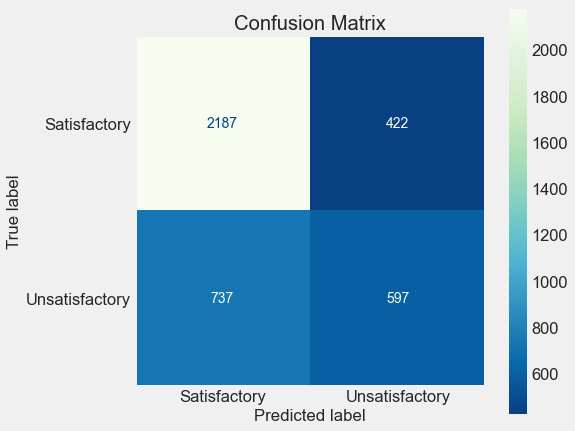

,Accuracy,F1,Recall,Precision
0,0.706061,0.507437,0.447526,0.585868


time: 9.67 s


In [30]:
f.confusion_report(knn_ss, X_test, y_test)

## Logistic Regression Classifier

In [31]:
LR = LogisticRegression(max_iter=1000, n_jobs=-1, random_state = 2021, verbose=0)

time: 810 µs


In [32]:
logreg_ss = make_pipeline(preprocessing_ss, LR)

time: 1.16 ms


### Fitting Model

In [33]:
logreg_ss.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x108c02580>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x108c02460>)])),
                ('logisticregression',
                 LogisticRegression(max_iter=1000, n_jobs=-1,
                                    random_state=2021))])

time: 4.07 s


In [34]:
# f.pickle_model(logreg_ss, 'logreg_ss')

time: 946 µs


### Cross Val Scores

In [35]:
# checking cross val scores
modeling.report(logreg_ss, X_train, y_train, 'logreg_ss',\
                'LogReg SS()')

logreg_ss has an average Accuracy of 0.7290337926831666
logreg_ss has an average F1 of 0.515244528510365
logreg_ss has an average Recall of 0.42614013732833955
logreg_ss has an average Precision of 0.6523442559571027
time: 4.51 s


### Test Data Confusion Matrix

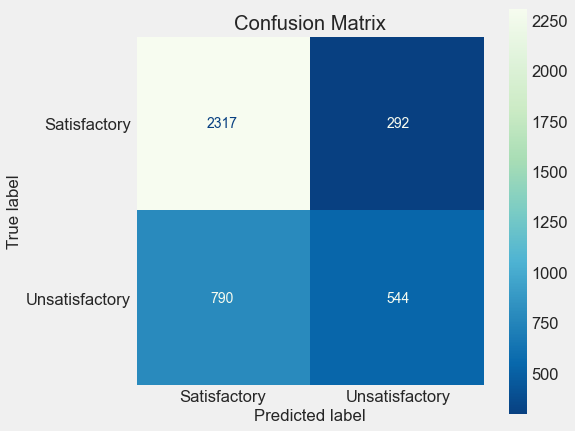

,Accuracy,F1,Recall,Precision
0,0.72559,0.501382,0.407796,0.650718


time: 217 ms


In [36]:
f.confusion_report(logreg_ss, X_test, y_test)

## Support Vector Machine

In [37]:
SVC = SVC()

time: 773 µs


In [38]:
svc_ss = make_pipeline(preprocessing_ss, SVC)

time: 860 µs


### Fitting Model

In [39]:
svc_ss.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x108c02580>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x108c02460>)])),
                ('svc', SVC())])

time: 6 s


In [40]:
# f.pickle_model(svc_ss, 'svc_ss')

time: 1.17 ms


### Cross Val Scores

In [41]:
# checking cross val scores
modeling.report(svc_ss, X_train, y_train, 'svc_ss',\
                'Support Vector CLF SS()')

svc_ss has an average Accuracy of 0.7396009714793256
svc_ss has an average F1 of 0.5239123646451612
svc_ss has an average Recall of 0.42463264669163553
svc_ss has an average Precision of 0.6861653961581029
time: 22.5 s


### Test Data Confusion Matrix

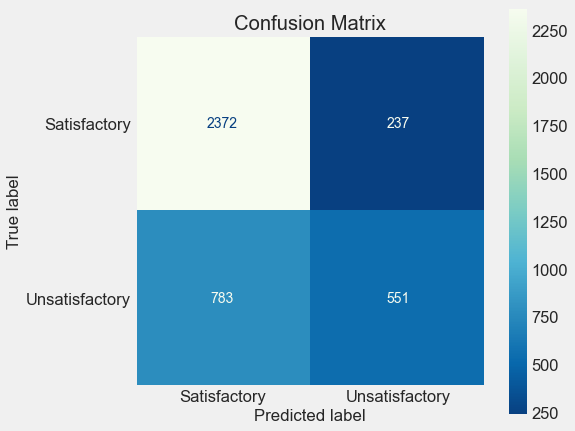

,Accuracy,F1,Recall,Precision
0,0.741314,0.519321,0.413043,0.699239


time: 6.54 s


In [42]:
f.confusion_report(svc_ss, X_test, y_test)

## Linear Support Vector Machine

In [43]:
LSVC = LinearSVC()

time: 723 µs


In [44]:
lsvc_ss = make_pipeline(preprocessing_ss, LSVC)

time: 844 µs


### Fitting Model

In [45]:
lsvc_ss.fit(X_train, y_train)

/Users/dsbox/opt/anaconda3/envs/oo/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x108c02580>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x108c02460>)])),
                ('linearsvc', LinearSVC())])

time: 693 ms


In [46]:
# f.pickle_model(lsvc_ss, 'lsvc_ss')

time: 609 µs


### Cross Val Scores

In [47]:
# checking cross val scores
modeling.report(lsvc_ss, X_train, y_train, 'lsvc_ss',\
                'Linear SVC SS()')

/Users/dsbox/opt/anaconda3/envs/oo/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/dsbox/opt/anaconda3/envs/oo/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/dsbox/opt/anaconda3/envs/oo/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/dsbox/opt/anaconda3/envs/oo/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


lsvc_ss has an average Accuracy of 0.7270893328496191
lsvc_ss has an average F1 of 0.502271904756208
lsvc_ss has an average Recall of 0.4073957553058677
lsvc_ss has an average Precision of 0.655599878704161
time: 2.65 s


/Users/dsbox/opt/anaconda3/envs/oo/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


### Test Data Confusion Matrix

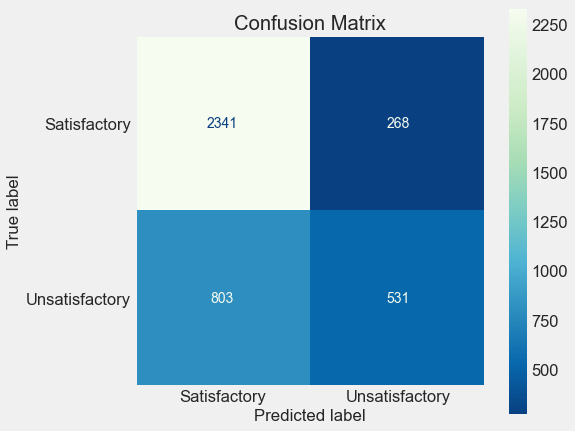

,Accuracy,F1,Recall,Precision
0,0.728379,0.49789,0.398051,0.664581


time: 193 ms


In [48]:
f.confusion_report(lsvc_ss, X_test, y_test)

## Decision Tree

In [49]:
DT = DecisionTreeClassifier(random_state=2021)

time: 853 µs


In [50]:
dt_ss = make_pipeline(preprocessing_ss, DT)

time: 895 µs


### Fitting Model

In [51]:
dt_ss.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x108c02580>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x108c02460>)])),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(random_state=2021))])

time: 503 ms


In [52]:
# f.pickle_model(dt_ss, 'dt_ss')

time: 752 µs


### Cross Val Scores

In [53]:
# checking cross val scores
modeling.report(dt_ss, X_train, y_train, 'dt_ss',\
                'Decision Tree CLF SS()')

dt_ss has an average Accuracy of 0.6714575942840701
dt_ss has an average F1 of 0.520352320272451
dt_ss has an average Recall of 0.5268670411985019
dt_ss has an average Precision of 0.5141644818028972
time: 1.81 s


### Test Data Confusion Matrix

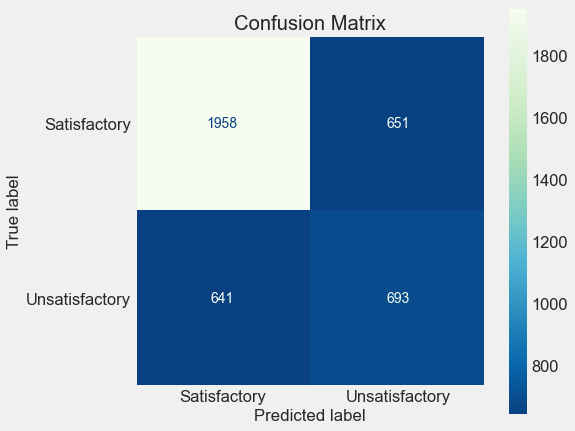

,Accuracy,F1,Recall,Precision
0,0.672331,0.51755,0.51949,0.515625


time: 192 ms


In [54]:
f.confusion_report(dt_ss, X_test, y_test)

## Bagging Classifier

In [55]:
BCLF = BaggingClassifier(base_estimator=DT, random_state=2021)

time: 835 µs


In [56]:
bclf_ss = make_pipeline(preprocessing_ss, BCLF)

time: 886 µs


### Fitting Model

In [57]:
bclf_ss.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x108c02580>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x108c02460>)])),
                ('baggingclassifier',
                 BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=2021),
                                   random_state=2021))])

time: 3.08 s


In [58]:
# f.pickle_model(bclf_ss, 'bclf_ss')

time: 605 µs


### Cross Val Scores

In [59]:
# checking cross val scores
modeling.report(bclf_ss, X_train, y_train, 'bclf_ss',\
                'Bagging CLF SS()')

bclf_ss has an average Accuracy of 0.7337673775240858
bclf_ss has an average F1 of 0.5426390697912983
bclf_ss has an average Recall of 0.4671320224719101
bclf_ss has an average Precision of 0.6482107500659166
time: 11.2 s


### Test Data Confusion Matrix

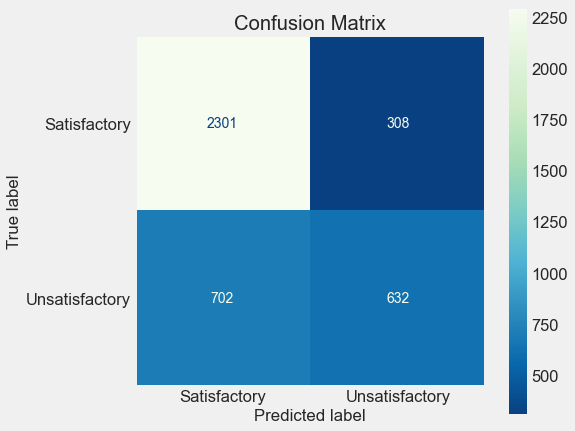

,Accuracy,F1,Recall,Precision
0,0.74385,0.555849,0.473763,0.67234


time: 263 ms


In [60]:
f.confusion_report(bclf_ss, X_test, y_test)

## Random Forest Classifier

In [61]:
RF = RandomForestClassifier(n_jobs=-1, random_state=2021)

time: 818 µs


In [62]:
rf_ss = make_pipeline(preprocessing_ss, RF)

time: 939 µs


### Fitting Model

In [63]:
rf_ss.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x108c02580>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x108c02460>)])),
                ('randomforestclassifier',
                 RandomForestClassifier(n_jobs=-1, random_state=2021))])

time: 2.07 s


In [64]:
# f.pickle_model(rf_ss, 'rf_ss')

time: 660 µs


### Cross Val Scores

In [65]:
# checking cross val scores
modeling.report(rf_ss, X_train, y_train, 'rf_ss',\
                'Random Forest SS()')

rf_ss has an average Accuracy of 0.7454350658286258
rf_ss has an average F1 of 0.5641395389032287
rf_ss has an average Recall of 0.4878732833957553
rf_ss has an average Precision of 0.6703223807131137
time: 10.6 s


### Test Data Confusion Matrix

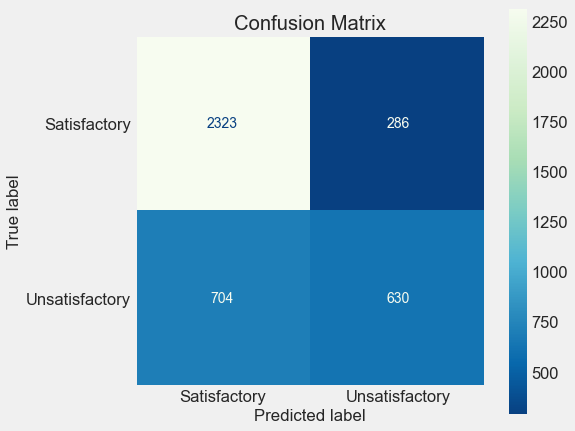

,Accuracy,F1,Recall,Precision
0,0.748922,0.56,0.472264,0.687773


time: 488 ms


In [66]:
f.confusion_report(rf_ss, X_test, y_test)

## AdaBoost

In [67]:
ADA = AdaBoostClassifier(base_estimator=DT, random_state=2021)

time: 857 µs


In [68]:
ada_ss = make_pipeline(preprocessing_ss, ADA)

time: 1.09 ms


### Fitting Model

In [69]:
ada_ss.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x108c02580>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x108c02460>)])),
                ('adaboostclassifier',
                 AdaBoostClassifier(base_estimator=DecisionTreeClassifier(random_state=2021),
                                    random_state=2021))])

time: 553 ms


In [70]:
# f.pickle_model(ada_ss, 'ada_ss')

time: 566 µs


### Cross Val Scores

In [71]:
# checking cross val scores
modeling.report(ada_ss, X_train, y_train, 'ada_ss',\
                'AdaBoost SS()')

ada_ss has an average Accuracy of 0.6760224390993621
ada_ss has an average F1 of 0.5283426976914845
ada_ss has an average Recall of 0.5366145443196004
ada_ss has an average Precision of 0.5206110814641016
time: 1.88 s


### Test Data Confusion Matrix

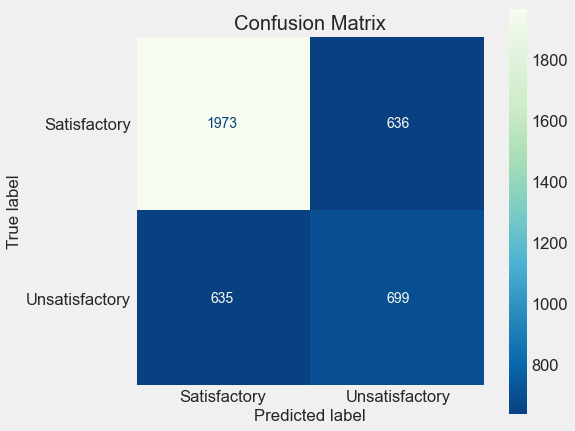

,Accuracy,F1,Recall,Precision
0,0.677657,0.523792,0.523988,0.523596


time: 200 ms


In [72]:
f.confusion_report(ada_ss, X_test, y_test)

## XGBoost

In [73]:
XGB = XGBClassifier(use_label_encoder=False)

time: 813 µs


In [74]:
xgb_ss = make_pipeline(preprocessing_ss, XGB)

time: 901 µs


### Fitting Model

In [75]:
%%capture --no-display
xgb_ss.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x108c02580>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x108c02460>)])),
                ('xgbclassifier',
                 XGBClassifie...
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estima

time: 742 ms


In [76]:
# f.pickle_model(xgb_ss, 'xgb_ss')

time: 779 µs


### Cross Val Scores

In [77]:
%%capture --no-display
# checking cross val scores
modeling.report(xgb_ss, X_train, y_train, 'xgb_ss',\
                'XGBoost SS()')

time: 3.29 s


### Test Data Confusion Matrix

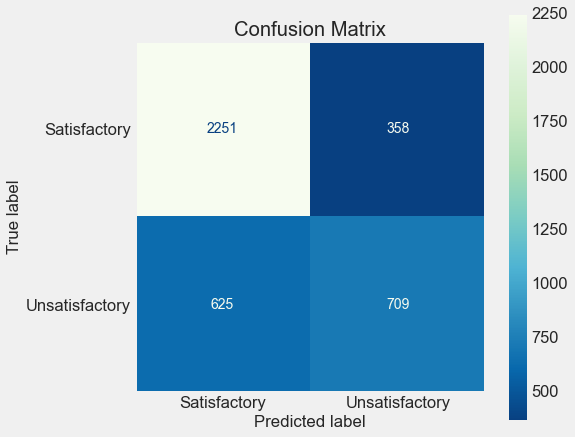

,Accuracy,F1,Recall,Precision
0,0.750697,0.590587,0.531484,0.66448


time: 325 ms


In [78]:
%%capture --no-display
f.confusion_report(xgb_ss, X_test, y_test)

## Model Summary 8

In [79]:
modeling.history

,Name,Accuracy,F1,Recall,Precision,CV_Time(sec),Notes
0,dt_ss,0.671458,0.520352,0.526867,0.514164,1.802259,Decision Tree CLF SS()
1,ada_ss,0.676022,0.528343,0.536615,0.520611,1.876702,AdaBoost SS()
2,knn_ss,0.705107,0.514976,0.463380,0.579926,4.502180,KNN SS()
3,lsvc_ss,0.727089,0.502272,0.407396,0.655600,2.648705,Linear SVC SS()
4,logreg_ss,0.729034,0.515245,0.426140,0.652344,4.511478,LogReg SS()
5,bclf_ss,0.733767,0.542639,0.467132,0.648211,11.182111,Bagging CLF SS()
6,svc_ss,0.739601,0.523912,0.424633,0.686165,22.528166,Support Vector CLF SS()
7,rf_ss,0.745435,0.564140,0.487873,0.670322,10.643083,Random Forest SS()
8,xgb_ss,0.751015,0.591966,0.534361,0.664813,3.288996,XGBoost SS()


time: 10.3 ms


## Voting Classifier
Using the top three model in a voting classifier.

In [80]:
clf1 = BCLF
clf2 = RF
clf3 = XGB

estimators = [('bclf',clf1), ('rf', clf2), ('xgb', clf3)]

VC = VotingClassifier(estimators=estimators, voting='hard', n_jobs=-1)

time: 1.24 ms


In [81]:
vc_ss = make_pipeline(preprocessing_ss, VC)

time: 967 µs


### Fitting Model

In [82]:
%%capture --no-display
vc_ss.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x108c02580>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x108c02460>)])),
                ('votingclassifier',
                 VotingCla...
                                                             interaction_constraints='',
                                                             learning_rate=0.300000012,
                                                             max_delta_step=0,
                                                             max_depth=6,
   

time: 5.28 s


In [83]:
# f.pickle_model(vc_ss, 'vc_ss')

time: 831 µs


### Cross Val Scores

In [84]:
%%capture --no-display
# checking cross val scores
modeling.report(vc_ss, X_train, y_train, 'vc_ss',\
                'Voting CLF SS()')

time: 21.4 s


### Test Data Confusion Matrix

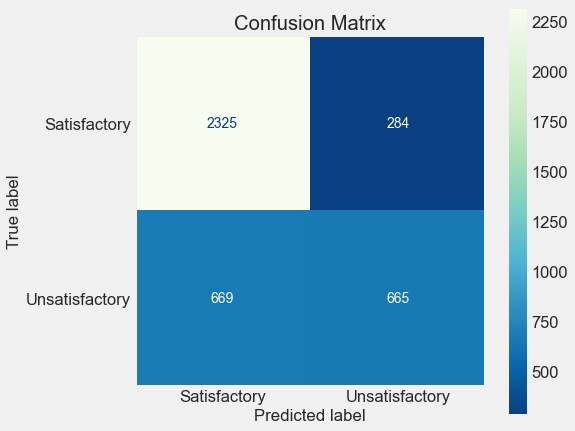

,Accuracy,F1,Recall,Precision
0,0.758306,0.582567,0.498501,0.700738


time: 838 ms


In [85]:
%%capture --no-display
f.confusion_report(vc_ss, X_test, y_test)

## Model Summary

In [86]:
modeling.history

,Name,Accuracy,F1,Recall,Precision,CV_Time(sec),Notes
0,dt_ss,0.671458,0.520352,0.526867,0.514164,1.802259,Decision Tree CLF SS()
1,ada_ss,0.676022,0.528343,0.536615,0.520611,1.876702,AdaBoost SS()
2,knn_ss,0.705107,0.514976,0.463380,0.579926,4.502180,KNN SS()
3,lsvc_ss,0.727089,0.502272,0.407396,0.655600,2.648705,Linear SVC SS()
4,logreg_ss,0.729034,0.515245,0.426140,0.652344,4.511478,LogReg SS()
5,bclf_ss,0.733767,0.542639,0.467132,0.648211,11.182111,Bagging CLF SS()
6,svc_ss,0.739601,0.523912,0.424633,0.686165,22.528166,Support Vector CLF SS()
7,rf_ss,0.745435,0.564140,0.487873,0.670322,10.643083,Random Forest SS()
8,xgb_ss,0.751015,0.591966,0.534361,0.664813,3.288996,XGBoost SS()
9,vc_ss,0.752452,0.577330,0.500370,0.683775,21.380517,Voting CLF SS()


time: 9.14 ms


## Neural Network

### Create Model

In [87]:
def create_model():
    # building model
    model = Sequential()
    model.add(Dense(64, input_dim=40, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # compiling
    model.compile(loss='binary_crossentropy',
                 optimizer='adam',
                 metrics=['accuracy'])
    return model

time: 1.5 ms


In [88]:
NN = KerasClassifier(build_fn=create_model,
                     epochs=10,
                     batch_size=32,
                     verbose=0)

time: 1.53 ms


### Pipeline

In [89]:
nn_ss = make_pipeline(preprocessing_ss, NN)

time: 1.07 ms


### Fitting Models

In [90]:
%%capture --no-display
nn_ss.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x108c02580>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x108c02460>)])),
                ('kerasclassifier',
                 <tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x1818226a0>)])

time: 4.49 s


In [91]:
# f.pickle_model(nn_ss, 'nn_ss')

time: 740 µs


### Cross Val Scores

In [92]:
%%capture --no-display
modeling.report(nn_ss, X_train, y_train, 'nn_ss',\
                'Neural Net SS()')

time: 18.6 s


### Test Data Confusion Matrix

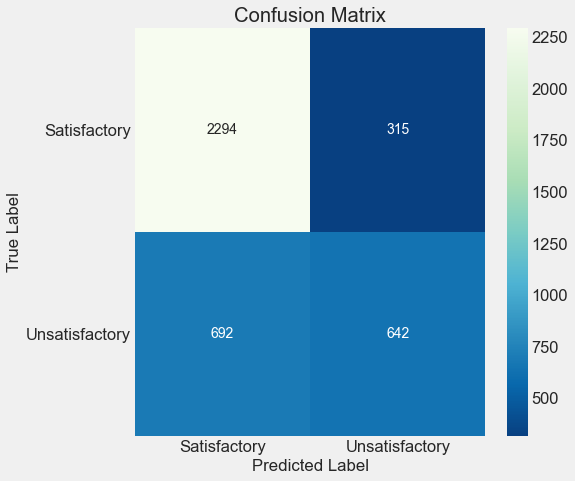

,Accuracy,F1,Recall,Precision
0,0.744611,0.560454,0.481259,0.670846


time: 575 ms


In [93]:
%%capture --no-display
f.confusion_report_nn(nn_ss, X_test, y_test)

## Model Summary 10

In [94]:
modeling.history

,Name,Accuracy,F1,Recall,Precision,CV_Time(sec),Notes
0,dt_ss,0.671458,0.520352,0.526867,0.514164,1.802259,Decision Tree CLF SS()
1,ada_ss,0.676022,0.528343,0.536615,0.520611,1.876702,AdaBoost SS()
2,knn_ss,0.705107,0.514976,0.463380,0.579926,4.502180,KNN SS()
3,lsvc_ss,0.727089,0.502272,0.407396,0.655600,2.648705,Linear SVC SS()
4,logreg_ss,0.729034,0.515245,0.426140,0.652344,4.511478,LogReg SS()
5,bclf_ss,0.733767,0.542639,0.467132,0.648211,11.182111,Bagging CLF SS()
10,nn_ss,0.734020,0.561374,0.506572,0.635354,18.592344,Neural Net SS()
6,svc_ss,0.739601,0.523912,0.424633,0.686165,22.528166,Support Vector CLF SS()
7,rf_ss,0.745435,0.564140,0.487873,0.670322,10.643083,Random Forest SS()
8,xgb_ss,0.751015,0.591966,0.534361,0.664813,3.288996,XGBoost SS()


time: 10.9 ms


In [95]:
clf1 = BCLF
clf2 = RF
clf3 = XGB

estimators = [('bclf',clf1), ('rf', clf2), ('xgb', clf3)]

VC = VotingClassifier(estimators=estimators, voting='hard', n_jobs=-1)

time: 1.19 ms


In [96]:
vc_ss = make_sm_pipeline(preprocessing_ss, sm, VC)

time: 1.06 ms


### Fitting Model

In [97]:
%%capture --no-display
vc_ss.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x108c02580>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x108c02460>)])),
                ('smote', SMOTE(random_state=2...
                                                             interaction_constraints='',
                                                             learning_rate=0.300000012,
                                                             max_delta_step=0,
                                                             max_depth=6,
                    

time: 9.04 s


In [98]:
# f.pickle_model(vc_ss, 'vc_ss')

time: 908 µs


### Cross Val Scores

In [99]:
%%capture --no-display
# checking cross val scores
modeling.report(vc_ss, X_train, y_train, 'vc_ss',\
                'Voting CLF SS()/SMOTE')

time: 33.1 s


### Test Data Confusion Matrix

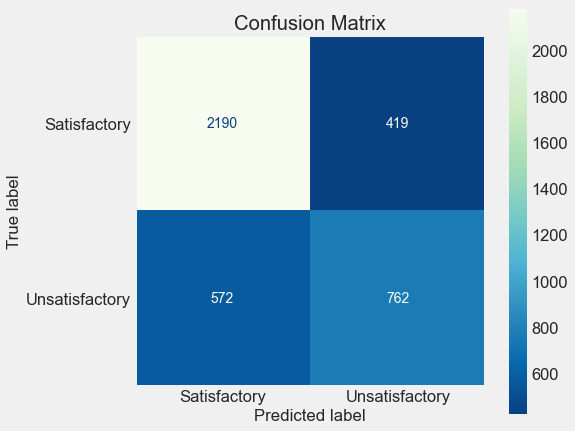

,Accuracy,F1,Recall,Precision
0,0.748669,0.605964,0.571214,0.645216


time: 801 ms


In [100]:
%%capture --no-display
f.confusion_report(vc_ss, X_test, y_test)

## Model Summary 9

In [101]:
modeling.history

,Name,Accuracy,F1,Recall,Precision,CV_Time(sec),Notes
0,dt_ss,0.671458,0.520352,0.526867,0.514164,1.802259,Decision Tree CLF SS()
1,ada_ss,0.676022,0.528343,0.536615,0.520611,1.876702,AdaBoost SS()
2,knn_ss,0.705107,0.514976,0.463380,0.579926,4.502180,KNN SS()
3,lsvc_ss,0.727089,0.502272,0.407396,0.655600,2.648705,Linear SVC SS()
4,logreg_ss,0.729034,0.515245,0.426140,0.652344,4.511478,LogReg SS()
5,bclf_ss,0.733767,0.542639,0.467132,0.648211,11.182111,Bagging CLF SS()
6,nn_ss,0.734020,0.561374,0.506572,0.635354,18.592344,Neural Net SS()
7,svc_ss,0.739601,0.523912,0.424633,0.686165,22.528166,Support Vector CLF SS()
8,rf_ss,0.745435,0.564140,0.487873,0.670322,10.643083,Random Forest SS()
11,vc_ss,0.749831,0.611218,0.581602,0.644917,33.050569,Voting CLF SS()/SMOTE


time: 11.2 ms


In [102]:
Audio(sound_file, autoplay=True)

time: 174 ms
